## **Class 15: Regularization**
- **Source**: I, Yeh (1988). Modeling of strength of high-performance concrete using artificial neural networks. Published in Cement and Concrete Research, Vol. 28, No. 12
- **Date**: 02/05/2025
- **Goal**: Create a basic prediction model and a feature explainer

In [24]:
#Paso 0 cargar todas estas librerias
import os
import logging
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
logger = logging.getLogger()
logger.setLevel(logging.INFO)

### **1. Data loading**
**Objective**: Obtain the data from source and get a first glimpse of their properties and presentation

--- en terminal para leer archivos de excel viejos
python -m pip install xlrd

In [2]:
#le puse ../ porque me daba error, debo ver como asegurar la ruta del archivo 
df_raw = pd.read_excel("../data/raw/concrete_data.xls")
df_raw.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Cement (component 1)(kg in a m^3 mixture)              1030 non-null   float64
 1   Blast Furnace Slag (component 2)(kg in a m^3 mixture)  1030 non-null   float64
 2   Fly Ash (component 3)(kg in a m^3 mixture)             1030 non-null   float64
 3   Water  (component 4)(kg in a m^3 mixture)              1030 non-null   float64
 4   Superplasticizer (component 5)(kg in a m^3 mixture)    1030 non-null   float64
 5   Coarse Aggregate  (component 6)(kg in a m^3 mixture)   1030 non-null   float64
 6   Fine Aggregate (component 7)(kg in a m^3 mixture)      1030 non-null   float64
 7   Age (day)                                              1030 non-null   int64  
 8   Concrete compressive strength(MPa, megapascals)  

In [3]:
df_raw.sample(10, random_state=2025)

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
565,295.80,0.00,0.00,185.70,0.00,1091.4,769.30,7,14.843729
690,288.00,192.00,0.00,192.00,0.00,932.0,717.80,7,23.523542
636,300.00,0.00,0.00,184.00,0.00,1075.0,795.00,28,26.848195
43,380.00,0.00,0.00,228.00,0.00,932.0,670.00,180,53.104131
720,203.50,305.30,0.00,203.50,0.00,963.4,630.00,90,51.863764
346,213.74,0.00,174.74,154.79,10.16,1053.5,776.35,28,40.148187
149,425.00,106.30,0.00,153.50,16.50,852.1,887.10,56,64.300532
376,376.00,0.00,0.00,214.60,0.00,1003.5,762.36,28,31.971002
605,236.00,0.00,0.00,194.00,0.00,968.0,885.00,3,6.467285
436,172.38,13.61,172.37,156.76,4.14,1006.3,856.40,28,33.687797


|Name|Description|Type|Units|
|----|-----------|----|-----|
|cement|Cement (component 1)(kg in a m^3 mixture)|Float|kg/m^3|
|blast_furnace_slag|Blast Furnace Slag (component 2)(kg in a m^3 mixture)|Float|kg/m^3|
|fly_ash|Fly Ash (component 3)(kg in a m^3 mixture)|Float|kg/m^3|
|water|Water (component 4)(kg in a m^3 mixture)|Float|kg/m^3|
|superplasticizer|Superplasticizer (component 5)(kg in a m^3 mixture)|Float|kg/m^3|
|coarse_aggregate|Coarse Aggregate (component 6)(kg in a m^3 mixture)|Float|kg/m^3|
|fine_aggregate|Fine Aggregate (component 7)(kg in a m^3 mixture)|Float|kg/m^3|
|age|Age (day)|Int|day|
|compressive_strength|Concrete compressive strength(MPa, megapascals)|Float|megapascals|

### **2. Data preprocessing**
**Objectives**: Perform the data cleaning, data transformation and data reduction steps to avoid data mistmatching, noisy data or data not wrangled

In [17]:
#cambiar nombre de raw a baking
df_baking = df_raw.copy()
df_baking.columns = ['cement','blast_furnace_slag','fly_ash','water','superplasticize','coarse_aggregate','fine_aggregate','age','compressive_strenght']
df_baking['cement'] = df_baking['cement']*1000
df = df_baking.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cement                1030 non-null   float64
 1   blast_furnace_slag    1030 non-null   float64
 2   fly_ash               1030 non-null   float64
 3   water                 1030 non-null   float64
 4   superplasticize       1030 non-null   float64
 5   coarse_aggregate      1030 non-null   float64
 6   fine_aggregate        1030 non-null   float64
 7   age                   1030 non-null   int64  
 8   compressive_strenght  1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.6 KB


### **3. Exploratory Data Analysis**
**Objective**: Summarize the main characteristics of the dataset using descriptive statistics and data visualization methods

In [5]:
df_train, df_test =train_test_split(df,test_size=0.2,random_state=2025)
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 824 entries, 0 to 823
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cement                824 non-null    float64
 1   blast_furnace_slag    824 non-null    float64
 2   fly_ash               824 non-null    float64
 3   water                 824 non-null    float64
 4   superplasticize       824 non-null    float64
 5   coarse_aggregate      824 non-null    float64
 6   fine_aggregate        824 non-null    float64
 7   age                   824 non-null    int64  
 8   compressive_strenght  824 non-null    float64
dtypes: float64(8), int64(1)
memory usage: 58.1 KB


In [18]:
#estadística descriptiva .describe() transpuesta .T
display(df_train.describe().T)
#Calcular el Rango Intercuartílico (IQR):IQR = Q3 - Q1
#Mediana= Quartil 2
#Media y STDev cuando son iguales o cercanas hay mucha dispersión 

,count,mean,std,min,25%,50%,75%,max
cement,824.0,278074.320388,105202.345965,102000.000000,190255.000000,255000.000000,350000.000000,540000.000000
blast_furnace_slag,824.0,76.231311,86.630413,0.000000,0.000000,26.000000,145.000000,359.400000
fly_ash,824.0,53.503083,64.244911,0.000000,0.000000,0.000000,118.270000,200.100000
water,824.0,181.901396,21.936752,121.750000,164.900000,185.700000,193.000000,247.000000
superplasticize,824.0,6.186624,6.094910,0.000000,0.000000,6.325000,10.300000,32.200000
coarse_aggregate,824.0,971.264211,77.333406,801.000000,932.000000,968.000000,1028.400000,1134.300000
fine_aggregate,824.0,773.822100,80.960805,594.000000,729.750000,779.510000,825.125000,992.600000
age,824.0,46.007282,63.292854,1.000000,12.250000,28.000000,56.000000,365.000000
compressive_strenght,824.0,35.512051,16.683885,2.331808,23.728144,33.729166,45.367521,82.599225


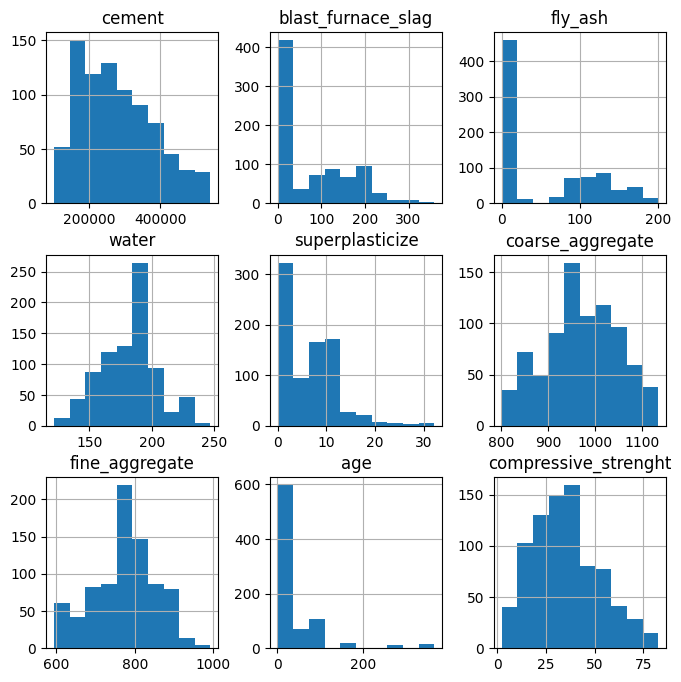

In [7]:
df_train.hist(figsize=(8, 8))
plt.show()


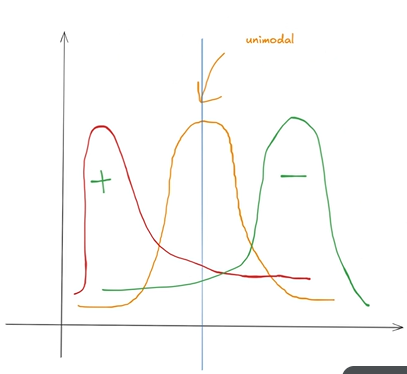

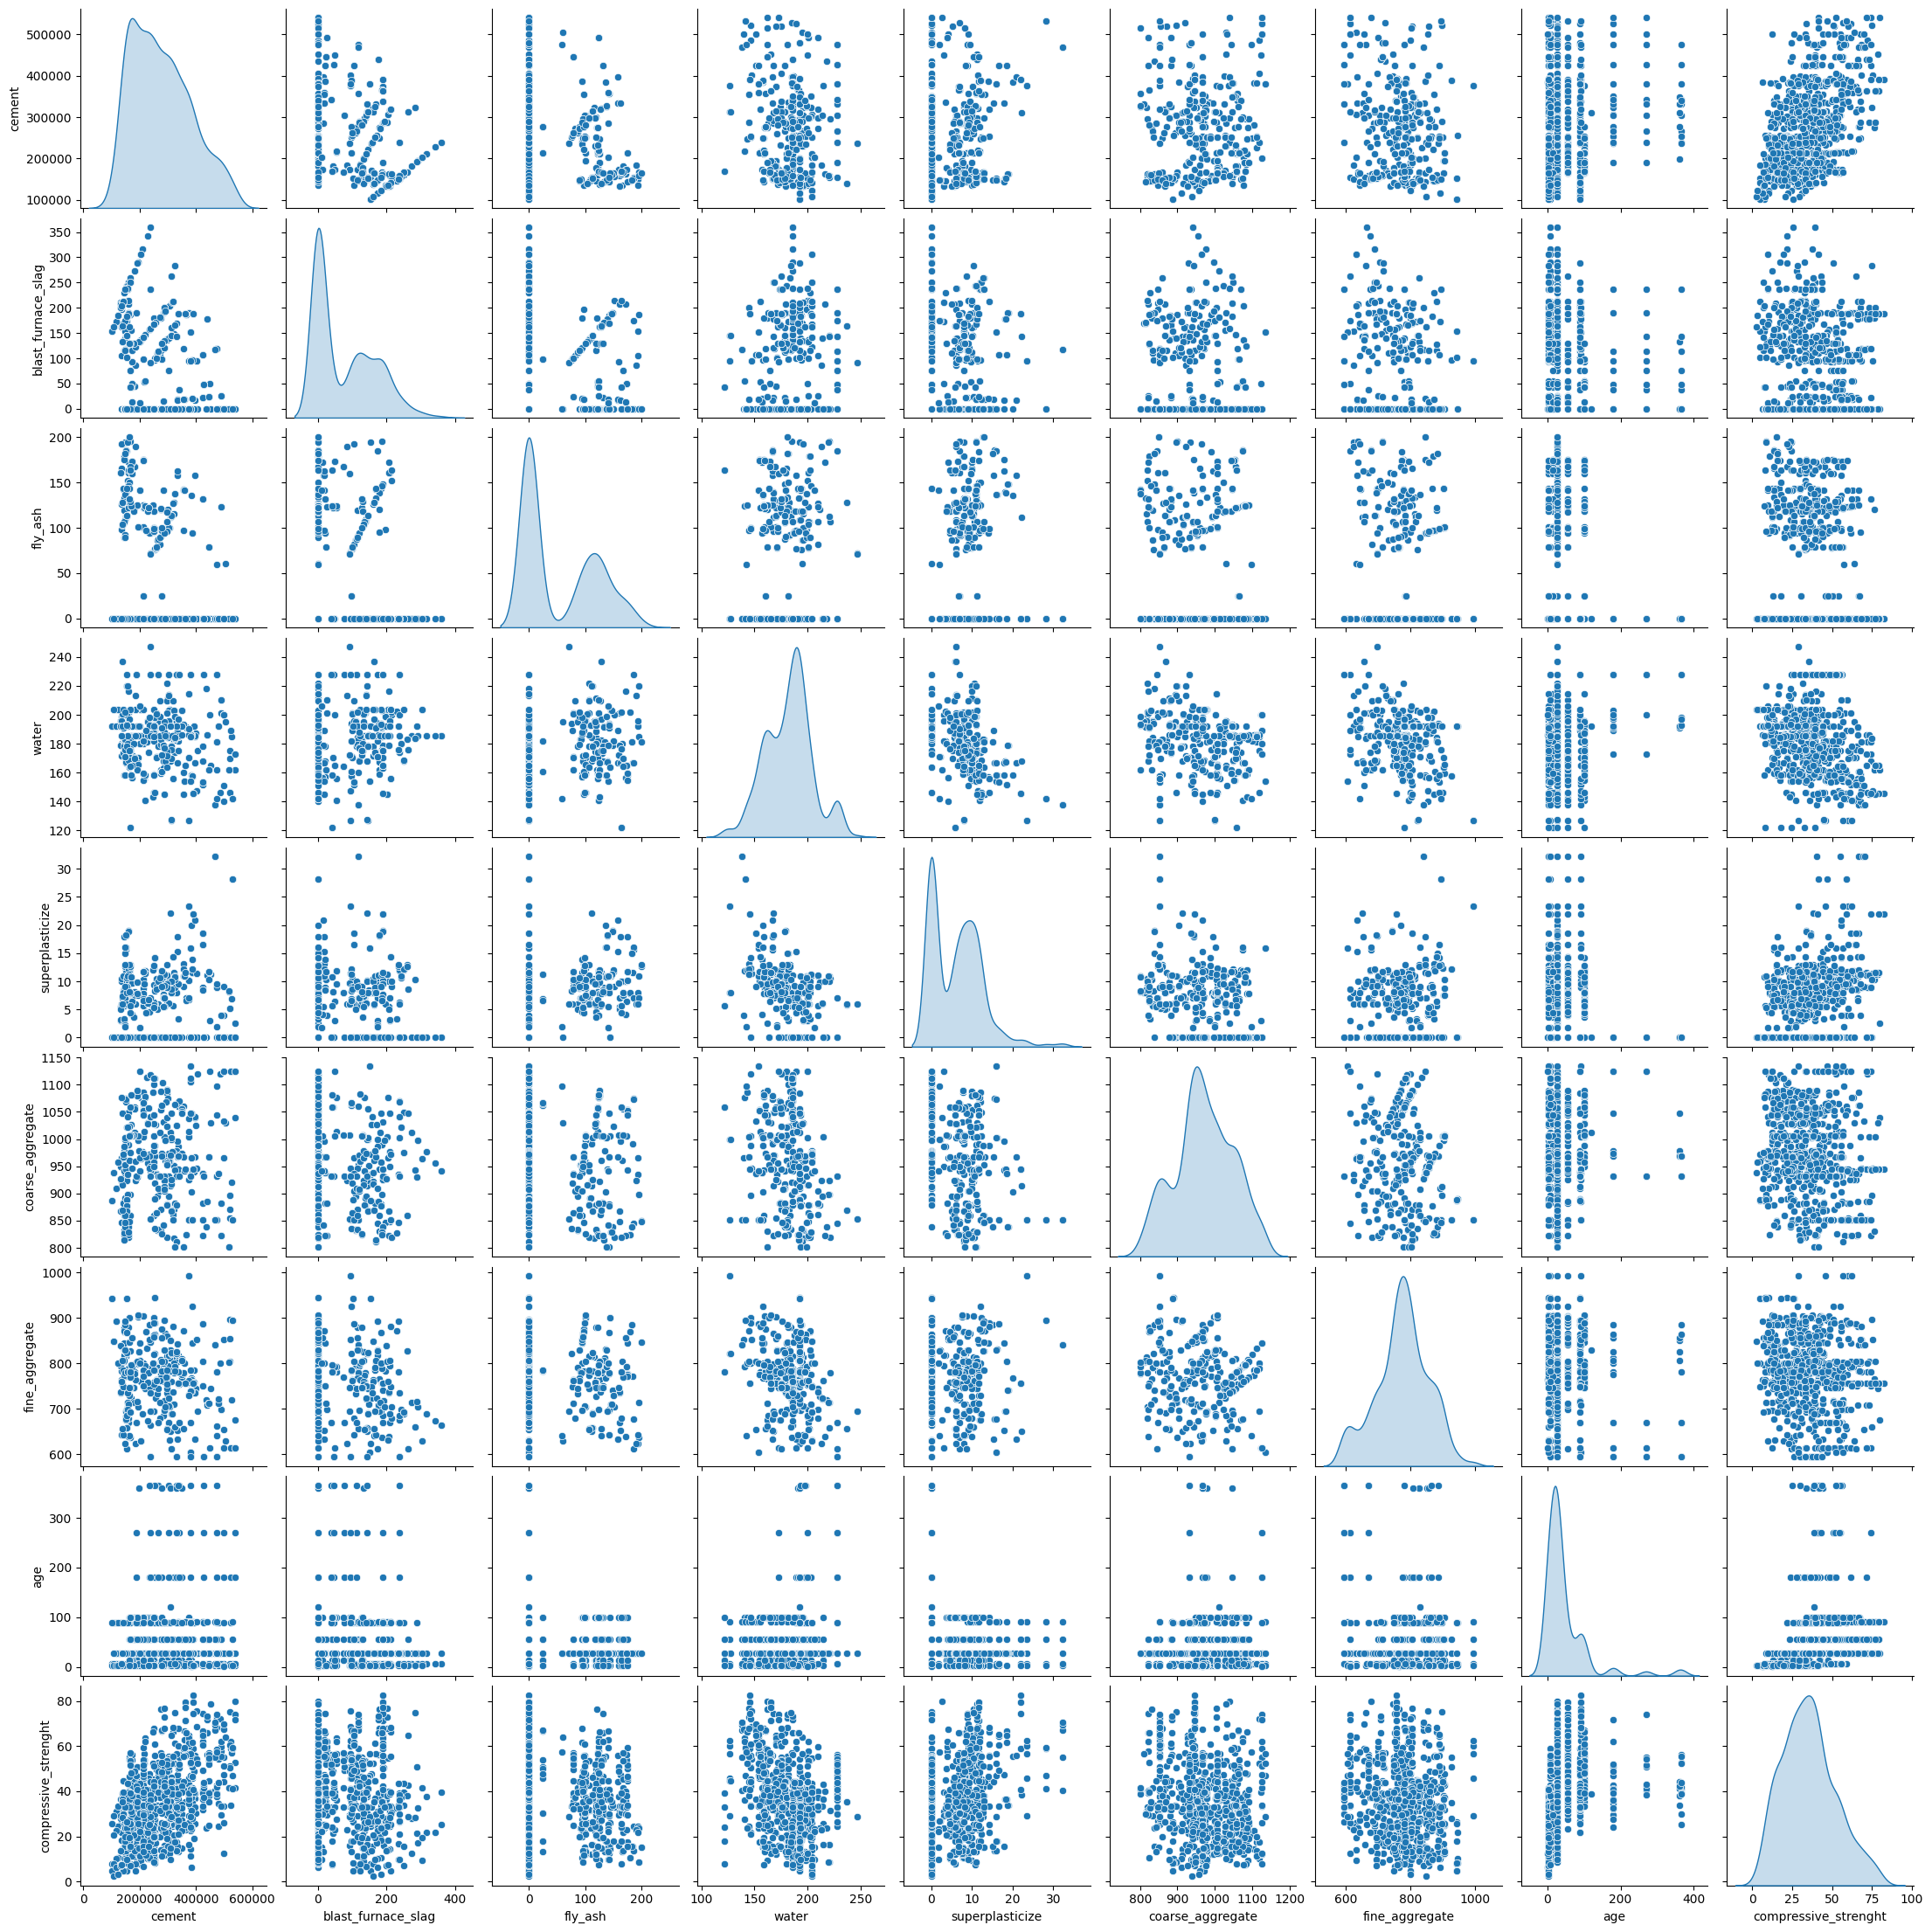

In [8]:
sns.pairplot(df_train,diag_kind='kde')
plt.show()

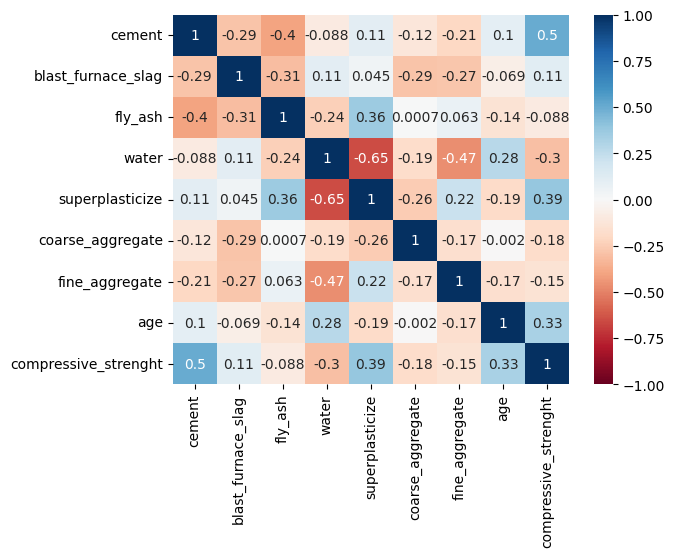

In [9]:
sns.heatmap(df_train.corr(),vmin=-1,vmax=1,cmap='RdBu',annot=True)
plt.show()

## Regla 0:
se asume que hay una relacion lineal entre las variables independientes y la variable dependiente
## Regla 1:
dos o mas variables no pueden estar correlacionadas (mas de 0.75 o menos de -0.75)
## Regla 2: 
las residuales de nuestra prediccion deben tener una distribucion simetrica
## Regla 3:
los residuales deben tener una dispersion homogenea

### **4. Machine learning**
**Objective**: Create a model that learns from data to make predictions and generalize to unseen data, and thus perform tasks without explicit instructions

In [10]:
X_train = df_train.drop('compressive_strenght',axis=1)
y_train = df_train['compressive_strenght']
x_test = df_test.drop('compressive_strenght', axis=1)
y_test = df_test['compressive_strenght']

In [25]:
#cada paso que le agregamos al pipeline debe tener nombre, paso 1 scaler
num_proc = Pipeline([
    ('scaler',MinMaxScaler())
])
lreg_p = Pipeline([
    ('num_processor',num_proc),
    ('lreg',LinearRegression())
])

In [28]:
lreg_p.fit(X_train,y_train)

Pipeline(steps=[('num_processor', Pipeline(steps=[('scaler', MinMaxScaler())])),
                ('lreg', LinearRegression())])

In [29]:
lreg = LinearRegression()
#vector de aprendizaje, que la maquina aprenda a buscar esos valores
lreg.fit(X_train,y_train)

LinearRegression()

In [32]:
#una vez hecho el aprendizaje debemos hacer la predicción 
#predecir sobre el dataset de prueba
y_hat = lreg_p.predict(x_test)
print(f'MSE: {mean_squared_error(y_test, y_hat)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_hat))}')
print(f'R2: {r2_score(y_test, y_hat)}')


MSE: 114.69591216414433
RMSE: 10.709617741270897
R2: 0.5905426768547533


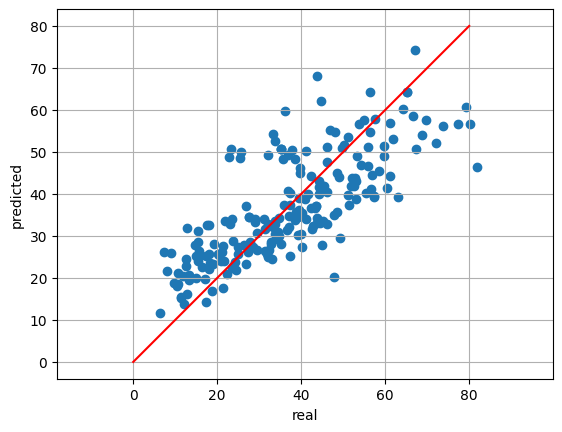

In [33]:
plt.scatter(y_test,y_hat)
plt.plot([0,80],[0,80],color='r')
plt.xlabel('real')
plt.ylabel('predicted')
plt.grid(True)
plt.axis('equal')
plt.show()

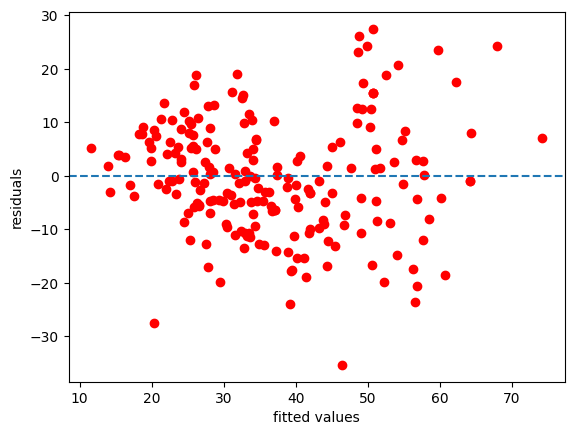

In [34]:
#vamos a sacar los residuales
resid = y_hat-y_test
plt.scatter(y_hat,resid,c='r')
plt.axhline(0,linestyle='--')
plt.xlabel('fitted values')
plt.ylabel('residuals')
plt.show()

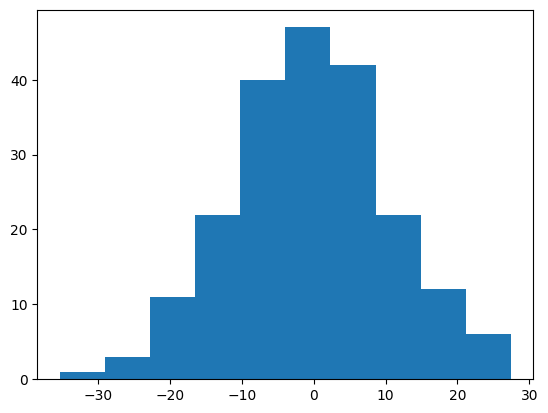

In [35]:
plt.hist(resid)
plt.show()

In [36]:
print(f'intercept:{lreg.intercept_:.2f}') #beta_0: si todas las variables independientes fueran cero, el valor esperado de la variable dependiente sería el resultado de abajo
print(f'coeficients:{lreg.coef_}') #beta_1, beta:2...

intercept:-32.89
coeficients:[ 1.22038807e-04  1.04897613e-01  9.40198654e-02 -1.29851596e-01
  3.22221218e-01  1.93374230e-02  2.46217848e-02  1.13637320e-01]


-intercept:-32.89

-coeficients:[ 0.00012203881  0.10489761  0.09401987 -0.1298516   0.32222122  0.01933742
  0.02462178  0.11363732]

-32.89 + cement * 0.00012203881 + slag * 0.10489761 + ash * 0.09401987 + water * -0.1298516 + superplasticizer *0.32222122 + coarse*0.01933742 + fine*0.02462178 +age ...

##### cada vez que sumo una unidad de cemento la resistencia a la compresion sube 0.122.... cada que agrego una unidad de agua la resistencia a la compresion baja -0.1298

#### Q: de todas las variables cuales la mas importante en la prediccion? 
#### R:es la variable con el coeficiente mas grande
#### Ex: en este caso es -superplast- con 0.3222
#### Ex: las menos significativas son -fine_aggregate- con 0.01933

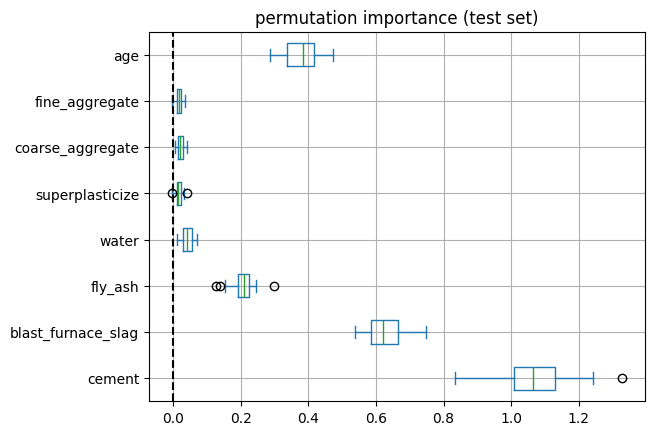

In [37]:
importance = permutation_importance(lreg,x_test, y_test,n_repeats=25,random_state=2025)
importance_df = pd.DataFrame(importance.importances.T,columns=x_test.columns)
ax= importance_df.plot.box(vert=False)
ax.axvline(x=0,color='k',linestyle='--')
ax.set_title('permutation importance (test set)')
ax.grid(True)
plt.show()